In [1]:
import numpy as np
from uncertainties import unumpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
d_orig = eval(open('./catalogue_2d_cnnntrk_3x100k_256_dot0001.txt').read())

In [3]:
keys = d_orig.keys()

In [4]:
def bootstrap_mean(d, keys, remove_two=True):
    '''
    Returns a dictionary with one entry per method name
    Each entry consists of a list of [mu, mean, std] elements
    '''
    bs_forfit = {}

    for k in keys:
        mean_auc = []
        if remove_two:
            results = sorted(d[k])[2:]
        else:
            results = d[k]
        for _ in range(10000): 
            choice = np.random.choice(results, len(results)) # choose 10 AUCs
            mean_auc.append(
                np.random.normal(unumpy.nominal_values(choice), unumpy.std_devs(choice)).mean()
            ) # modify AUCs up or down by their uncertainty
            
        # take mean of 10k means and std of the origina means
        bs_forfit[k] = np.array([np.mean(mean_auc), np.std(unumpy.nominal_values(results))])
        
        
    return bs_forfit

In [5]:
x, y = np.hsplit(np.array(keys), 2)

In [6]:
d = bootstrap_mean(d_orig, keys)

In [7]:
# z = np.array([np.mean(unumpy.nominal_values(d[k])) for k in keys])

In [8]:
# stderr = np.array([np.std(unumpy.nominal_values(d[k])) for k in keys])

In [9]:
z = np.array([d[k][0] for k in keys])

In [10]:
stderr = np.array([d[k][1] for k in keys])

In [11]:
# LEVELS = 7

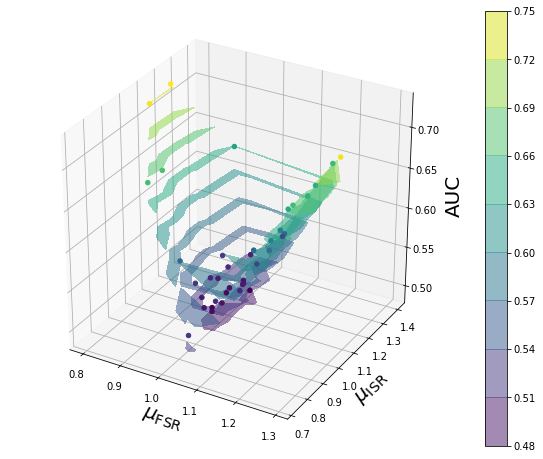

In [12]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
ax.scatter(x.ravel(), y.ravel(), z, alpha=1, c=z) 
p = ax.tricontourf(x.ravel(), y.ravel(), z, alpha=0.5)
ax.set_xlabel(r'$\mu_\mathrm{FSR}$', fontsize=20)
ax.set_ylabel(r'$\mu_\mathrm{ISR}$', fontsize=20)
ax.set_zlabel('\nAUC', fontsize=20, rotation=90, linespacing=1)

plt.colorbar(p)

In [13]:
import matplotlib.tri as tri
triang = tri.Triangulation(x.ravel(), y.ravel())

Text(0,0.5,'$\\mu_\\mathrm{ISR}$')

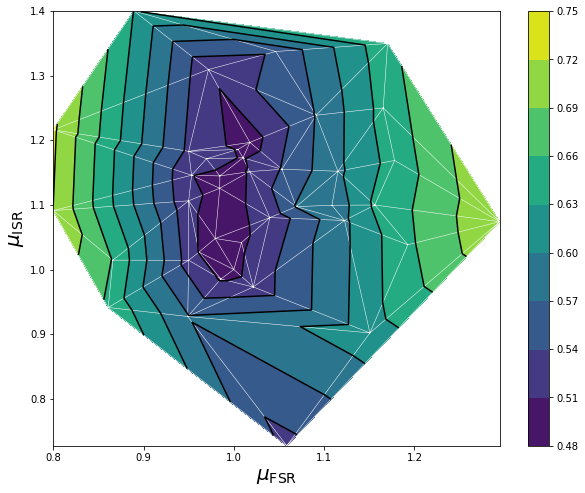

In [14]:
plt.figure(figsize=(10, 8))
# plt.gca().set_aspect('equal')
plt.triplot(triang, lw=0.5, color='white')
plt.tricontourf(triang, z)
plt.colorbar()
plt.tricontour(triang, z, colors='k')
plt.xlabel(r'$\mu_\mathrm{FSR}$', fontsize=20)
plt.ylabel(r'$\mu_\mathrm{ISR}$', fontsize=20)

In [15]:
refiner = tri.UniformTriRefiner(triang)
tri_refi, z_test_refi = refiner.refine_field(z, subdiv=3)

Text(0,0.5,'$\\mu_\\mathrm{ISR}$')

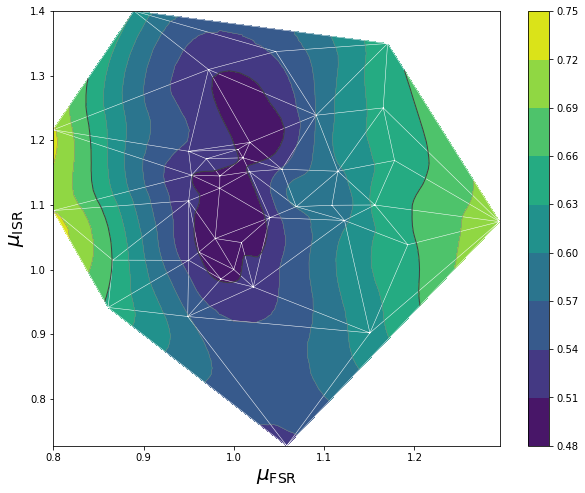

In [16]:
#-----------------------------------------------------------------------------
# Plot the triangulation and the high-res iso-contours
#-----------------------------------------------------------------------------
plt.figure(figsize=(10, 8))
# plt.gca().set_aspect('equal')
plt.triplot(triang, lw=0.5, color='white')

# levels = np.arange(0., 1., 0.025)
# cmap = plt.cm.get_cmap(name='terrain', lut=None)
p = plt.tricontourf(tri_refi, z_test_refi)#, levels=levels)#, cmap=cmap)
plt.tricontour(tri_refi, z_test_refi, # levels=levels,
               colors=['0.25', '0.5', '0.5', '0.5', '0.5'],
               linewidths=[1.0, 0.5, 0.5, 0.5, 0.5])
plt.colorbar(p)
plt.xlabel(r'$\mu_\mathrm{FSR}$', fontsize=20)
plt.ylabel(r'$\mu_\mathrm{ISR}$', fontsize=20)

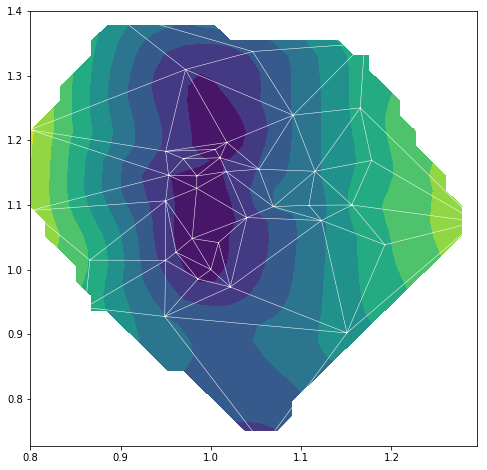

In [17]:
xi, yi = np.meshgrid(np.linspace(x.min(), x.max(), 30), np.linspace(y.min(), y.max(), 30))
interp_cubic_geom = tri.CubicTriInterpolator(triang, z, kind='geom')
zi_cubic_geom = interp_cubic_geom(xi, yi)
plt.figure(figsize=(8, 8))
plt.contourf(xi, yi, zi_cubic_geom)
plt.triplot(triang, lw=0.5, color='white')

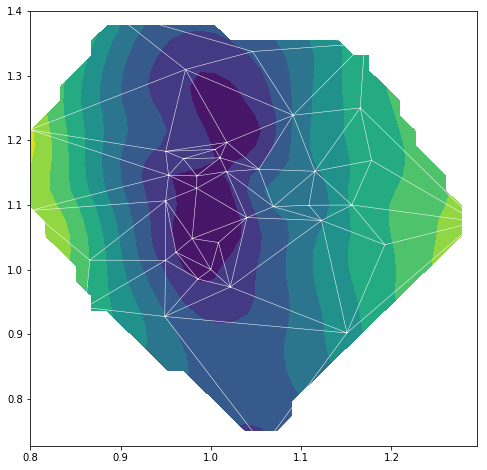

In [18]:
xi, yi = np.meshgrid(np.linspace(x.min(), x.max(), 30), np.linspace(y.min(), y.max(), 30))
interp_cubic_minE = tri.CubicTriInterpolator(triang, z, kind='min_E')
zi_cubic_minE = interp_cubic_minE(xi, yi)
plt.figure(figsize=(8, 8))
plt.contourf(xi, yi, zi_cubic_minE)
plt.triplot(triang, lw=0.5, color='white')

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, DotProduct
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process import kernels as gp_kernels

In [20]:
kernel = RBF(0.1, (0.1, 10.))

In [21]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, alpha=(stderr)**2, normalize_y=True)

In [22]:
gp.fit(np.array(keys), z)

GaussianProcessRegressor(alpha=array([2.53819e-04, 4.19672e-04, 5.28035e-04, 6.70868e-04, 2.40175e-04,
       8.25805e-04, 1.06452e-03, 1.03519e-03, 5.57230e-04, 2.57935e-04,
       8.98670e-04, 1.44815e-03, 4.98350e-04, 4.11850e-04, 4.99559e-04,
       2.84924e-04, 2.61433e-04, 4.57981e-04, 1.02081e-03, 8.80333e-04,
      ..., 6.69907e-05, 6.65790e-04,
       7.02065e-04, 3.97369e-04, 3.01782e-04, 8.93998e-04, 1.41173e-03]),
             copy_X_train=True, kernel=RBF(length_scale=0.1),
             n_restarts_optimizer=0, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [23]:
# mu_fsr_mesh = np.random.normal(loc=1.0, scale=0.1, size=(10000, 2))
mu_fsr_mesh = np.concatenate(
   (np.random.normal(1, 0.05, (20000, 1)),
   np.random.normal(1.05, 0.08, (20000, 1))), axis = 1
)

In [24]:
z_pred, sigma = gp.predict(mu_fsr_mesh, return_std=True)

In [25]:
z_pred

array([0.50986247, 0.53165011, 0.50545989, ..., 0.52125856, 0.59374233,
       0.51735695])

In [26]:
sigma

array([0.00429453, 0.00676029, 0.00468825, ..., 0.00962177, 0.03413481,
       0.00918283])

In [27]:
THRESHOLD = 0.0

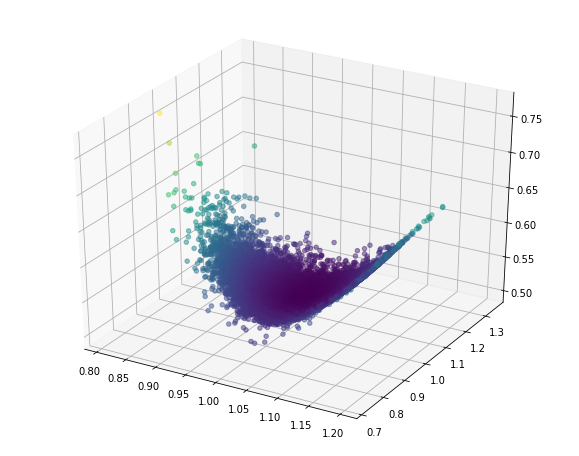

In [28]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
ax.scatter(
    mu_fsr_mesh[:, 0][z_pred > THRESHOLD],
    mu_fsr_mesh[:, 1][z_pred > THRESHOLD],
    z_pred[z_pred > THRESHOLD],
    alpha=0.5,
    c=z_pred[z_pred > THRESHOLD])

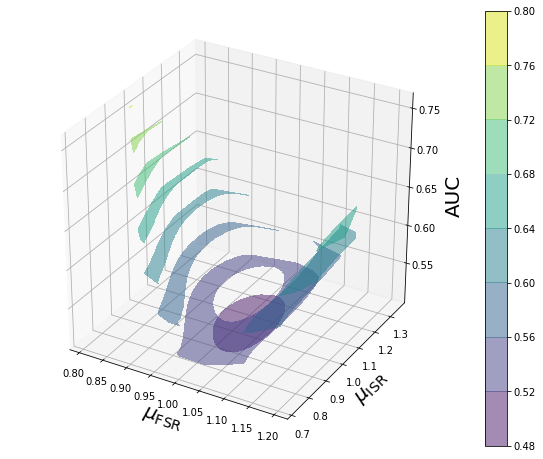

In [29]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
p = ax.tricontourf(mu_fsr_mesh[:, 0][z_pred > THRESHOLD],
                   mu_fsr_mesh[:, 1][z_pred > THRESHOLD],
                   z_pred[z_pred > THRESHOLD],
                   alpha=0.5) #tricontour(f)
ax.set_xlabel(r'$\mu_\mathrm{FSR}$', fontsize=20)
ax.set_ylabel(r'$\mu_\mathrm{ISR}$', fontsize=20)
ax.set_zlabel('\nAUC', fontsize=20, rotation=90, linespacing=1)

plt.colorbar(p)

Text(0,0.5,'$\\mu_\\mathrm{ISR}$')

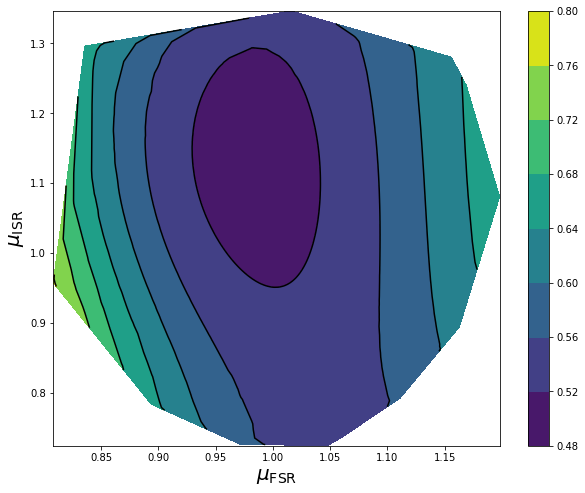

In [30]:
import matplotlib.tri as tri
triang = tri.Triangulation(mu_fsr_mesh[:, 0][z_pred > THRESHOLD], mu_fsr_mesh[:, 1][z_pred > THRESHOLD])
plt.figure(figsize=(10, 8))
# plt.gca().set_aspect('equal')
# plt.triplot(triang, lw=0.5, color='white')
plt.tricontourf(triang, z_pred[z_pred > THRESHOLD])
plt.colorbar()
plt.tricontour(triang, z_pred[z_pred > THRESHOLD], colors='k')
plt.xlabel(r'$\mu_\mathrm{FSR}$', fontsize=20)
plt.ylabel(r'$\mu_\mathrm{ISR}$', fontsize=20)

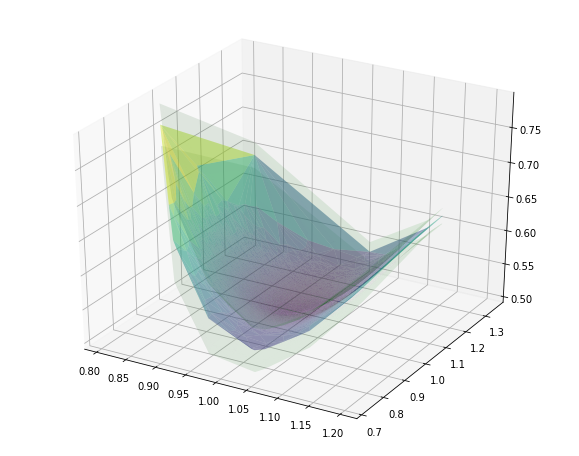

In [37]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

ax.plot_trisurf(mu_fsr_mesh[:, 0][z_pred > THRESHOLD],
                mu_fsr_mesh[:, 1][z_pred > THRESHOLD],
                (z_pred + sigma)[z_pred > THRESHOLD],
                color='green', alpha=0.1)

ax.plot_trisurf(mu_fsr_mesh[:, 0][z_pred > THRESHOLD],
                mu_fsr_mesh[:, 1][z_pred > THRESHOLD],
                (z_pred - sigma)[z_pred > THRESHOLD],
                color='green', alpha=0.1)

ax.plot_trisurf(mu_fsr_mesh[:, 0][z_pred > THRESHOLD],
                mu_fsr_mesh[:, 1][z_pred > THRESHOLD],
                z_pred[z_pred > THRESHOLD],
                cmap='viridis', alpha=0.5)


In [32]:
point_estimate = mu_fsr_mesh[z_pred.argmin()]

In [33]:
point_estimate

array([0.98336453, 1.1284083 ])

In [34]:
lowest_point = z_pred.min()
lowest_point

0.5017402104344763

In [35]:
lower = z_pred - 1 * sigma

consistent = mu_fsr_mesh[np.where(lower < lowest_point)[0]]

(0.7, 1.5)

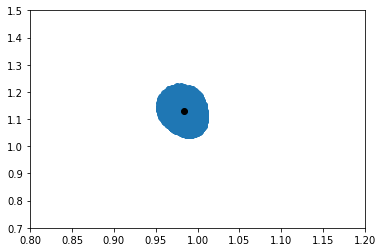

In [36]:
plt.scatter(*consistent.T)
plt.scatter(*point_estimate, color='black')
plt.xlim(0.8, 1.2)
plt.ylim(0.7, 1.5)